# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this exercise, I'll use different techniques to build models to identify the breed of a dog provided a picture. A number of algorithms will be tried and evaluated; and I will build a CNN model from scratch to compare with established models.

In the end, a number of user supplied images (downloaded from the web) will be fed to the model and the prediction will be generated.

Predicting dog breed is hard since they look alike. Some times it is even impossible for a human to tell them apart. That's why I will be using a pre-trained VGG16 model and transformed data to fine tune the model.

This is a project I built using Udacity's workspace.

### The Process

The process includes the following process.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create algorithm to make predictions
* [Step 6](#step6): Test algorithm with user images

---
<a id='step0'></a>
## Step 0: Import Datasets

Download human and dog datasets from Amazon AWS:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

* Save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [36]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [37]:
human_files[0]

'/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg'

<a id='step1'></a>
## Step 1: Detect Humans

In this section, I'll use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  One of these detectors has been downloaded and saved in the `haarcascades` directory.  In the next code cell, I'll demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


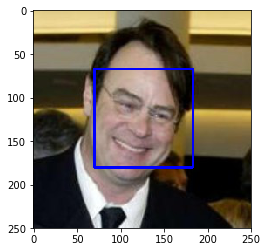

In [38]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

The human face detection function below will take an image and return 'True' if a human is predicted, and 'False' if otherwise.

In [39]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

The function in the cell below will evaluate the accuracy of the Human Face Detector.

Run it on 100 human faces and 100 dog faces and make a prediction.

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_detection, dog_detection=0, 0

for i in range(100):
    if face_detector(human_files_short[i]):
        human_detection+=1
    if face_detector(dog_files_short[i]):
        dog_detection+=1
print(f'{human_detection} times human faces detected in 100 human faces (Higher is better).')    
print(f'{dog_detection} times human faces detected in 100 dog faces (Lower is better).')    

98 times human faces detected in 100 human faces (Higher is better).
17 times human faces detected in 100 dog faces (Lower is better).


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, I will use a pretrained VGG-16 models to detect dog images.

The pre-trained models are availabe [here](http://pytorch.org/docs/master/torchvision/models.html). 

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [40]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

The function below accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.


In [41]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    data_transforms = transforms.Compose([
        transforms.Resize((224,224)), 
        transforms.ToTensor(), normalize])

    img=Image.open(img_path)
    img=data_transforms(img) 
    img=img.unsqueeze_(0)

    if use_cuda:
        img = img.cuda()
    
    value, idx = VGG16(img).squeeze().max(0)

    return idx.item() # predicted class index

In [10]:
VGG16_predict(dog_files[330])

273

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

The function below returns `True` if a dog is detected in an image (and `False` if not).

In [42]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):

    pred=False
    
    score=VGG16_predict(img_path)
    
    if (151<=score<=268):
        pred=True
    
    return pred # true/false

### Assess the Dog Detector

Run the dog detector on 100 human and 100 dog images to test its accuracy.

In [9]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogs_in_human_pics, dogs_in_dog_pics=0, 0

for i in range(100):
    if dog_detector(human_files_short[i]):
        dogs_in_human_pics+=1
    if dog_detector(dog_files_short[i]):
        dogs_in_dog_pics+=1
print(f'{dogs_in_human_pics} times dog faces detected in 100 human faces (Lower is better).')    
print(f'{dogs_in_dog_pics} times dog faces detected in 100 dog faces (Higher is better).')    

1 times dog faces detected in 100 human faces (Lower is better).
100 times dog faces detected in 100 dog faces (Higher is better).


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

In the following cells, I'll create a CNN model from scratch to detect dog breeds. As mentioned before, it is very challenging to pinpoint a dog's breed since very often they look alike. In the dataset there are 133 dog breeds, so a random guess will get us an accuracy of 0.75%. The target of this model is to achieve accuracy over 10%.


### Specify Data Loaders for the Dog Dataset

First, write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  

In [6]:
dog_class=['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog',
 '011.Australian_cattle_dog',
 '012.Australian_shepherd',
 '013.Australian_terrier',
 '014.Basenji',
 '015.Basset_hound',
 '016.Beagle',
 '017.Bearded_collie',
 '018.Beauceron',
 '019.Bedlington_terrier',
 '020.Belgian_malinois',
 '021.Belgian_sheepdog',
 '022.Belgian_tervuren',
 '023.Bernese_mountain_dog',
 '024.Bichon_frise',
 '025.Black_and_tan_coonhound',
 '026.Black_russian_terrier',
 '027.Bloodhound',
 '028.Bluetick_coonhound',
 '029.Border_collie',
 '030.Border_terrier',
 '031.Borzoi',
 '032.Boston_terrier',
 '033.Bouvier_des_flandres',
 '034.Boxer',
 '035.Boykin_spaniel',
 '036.Briard',
 '037.Brittany',
 '038.Brussels_griffon',
 '039.Bull_terrier',
 '040.Bulldog',
 '041.Bullmastiff',
 '042.Cairn_terrier',
 '043.Canaan_dog',
 '044.Cane_corso',
 '045.Cardigan_welsh_corgi',
 '046.Cavalier_king_charles_spaniel',
 '047.Chesapeake_bay_retriever',
 '048.Chihuahua',
 '049.Chinese_crested',
 '050.Chinese_shar-pei',
 '051.Chow_chow',
 '052.Clumber_spaniel',
 '053.Cocker_spaniel',
 '054.Collie',
 '055.Curly-coated_retriever',
 '056.Dachshund',
 '057.Dalmatian',
 '058.Dandie_dinmont_terrier',
 '059.Doberman_pinscher',
 '060.Dogue_de_bordeaux',
 '061.English_cocker_spaniel',
 '062.English_setter',
 '063.English_springer_spaniel',
 '064.English_toy_spaniel',
 '065.Entlebucher_mountain_dog',
 '066.Field_spaniel',
 '067.Finnish_spitz',
 '068.Flat-coated_retriever',
 '069.French_bulldog',
 '070.German_pinscher',
 '071.German_shepherd_dog',
 '072.German_shorthaired_pointer',
 '073.German_wirehaired_pointer',
 '074.Giant_schnauzer',
 '075.Glen_of_imaal_terrier',
 '076.Golden_retriever',
 '077.Gordon_setter',
 '078.Great_dane',
 '079.Great_pyrenees',
 '080.Greater_swiss_mountain_dog',
 '081.Greyhound',
 '082.Havanese',
 '083.Ibizan_hound',
 '084.Icelandic_sheepdog',
 '085.Irish_red_and_white_setter',
 '086.Irish_setter',
 '087.Irish_terrier',
 '088.Irish_water_spaniel',
 '089.Irish_wolfhound',
 '090.Italian_greyhound',
 '091.Japanese_chin',
 '092.Keeshond',
 '093.Kerry_blue_terrier',
 '094.Komondor',
 '095.Kuvasz',
 '096.Labrador_retriever',
 '097.Lakeland_terrier',
 '098.Leonberger',
 '099.Lhasa_apso',
 '100.Lowchen',
 '101.Maltese',
 '102.Manchester_terrier',
 '103.Mastiff',
 '104.Miniature_schnauzer',
 '105.Neapolitan_mastiff',
 '106.Newfoundland',
 '107.Norfolk_terrier',
 '108.Norwegian_buhund',
 '109.Norwegian_elkhound',
 '110.Norwegian_lundehund',
 '111.Norwich_terrier',
 '112.Nova_scotia_duck_tolling_retriever',
 '113.Old_english_sheepdog',
 '114.Otterhound',
 '115.Papillon',
 '116.Parson_russell_terrier',
 '117.Pekingese',
 '118.Pembroke_welsh_corgi',
 '119.Petit_basset_griffon_vendeen',
 '120.Pharaoh_hound',
 '121.Plott',
 '122.Pointer',
 '123.Pomeranian',
 '124.Poodle',
 '125.Portuguese_water_dog',
 '126.Saint_bernard',
 '127.Silky_terrier',
 '128.Smooth_fox_terrier',
 '129.Tibetan_mastiff',
 '130.Welsh_springer_spaniel',
 '131.Wirehaired_pointing_griffon',
 '132.Xoloitzcuintli',
 '133.Yorkshire_terrier']

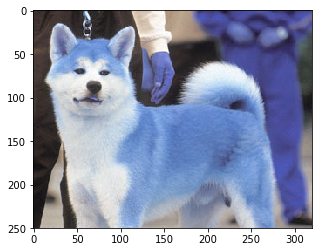

In [11]:
img = cv2.imread('/data/dog_images/train/004.Akita/Akita_00221.jpg')
plt.imshow(img)
plt.show()

In [12]:
# Remove this as this has been defined at top. Use only when testing the scratch model
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# check if CUDA is available
use_cuda = torch.cuda.is_available()

***Image augumentation to improve accuracy: use only on training data***

1. The images are resized by cropping to 64x64. I feel this is a good size as the features are visible to human eyes at this size. Plus the transformations will help tune the model.
2. The images are augmented by horizontal flipping and random rotation.

In [25]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

train_dir='/data/dog_images/train'
valid_dir='/data/dog_images/valid'
test_dir='/data/dog_images/test'

## Specify appropriate transforms, and batch_sizes
# data_transform = transforms.Compose([transforms.RandomResizedCrop(60), 
#                                       transforms.ToTensor()])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

valid_transform=test_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.ToTensor(),    
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   
    ])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  6680
Num validation images:  835
Num test images:  836


In [26]:
batch_size=20
num_workers=0

list(range(len(train_data)))
train_idx, valid_idx = list(range(len(train_data))), list(range(len(valid_data)))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [27]:
loaders_scratch={'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### Model Architecture

Create a CNN to classify dog breed.  

There are 3 convolution layers with 3x3 filters and 1 padding which ensure the image size will remain the same. There is a 2x2 max pooling layer after each convolution layer which reduces the image/feature size by half. So after 3 times the 64*64 images will become 8*8 features. Number of features will increase from 3(RGB) at the input layer to 16, then to 32, then to 64. So the final features will be 64*8*8. Those will be fed into 2 RELU layers and the linear combination will be output. The 25% drop out will reduce overfitting.

In [28]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 32x32x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 16x16x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 8x8x64 tensor)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 8 * 8 -> 500)
        self.fc1 = nn.Linear(64 * 8 * 8, 500)
        # linear layer (500 -> 133)
        self.fc2 = nn.Linear(500, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

### Specify Loss Function and Optimizer

Specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [29]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### Train and Validate the Model

Train and validate the model.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
 
            optimizer.zero_grad()
            
            output=model(data)
            loss=criterion(output, target)
            loss.backward()
            
            train_loss+=loss.item()
            optimizer.step()
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            output=model.forward(data)
            loss=criterion(output, target)

            valid_loss+=loss.item()
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [37]:
# train the model 
# Ran the training process two times, 20 epochs each. So altogether 40 epochs.  
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 1265.337711 	Validation Loss: 149.876883
Validation loss decreased (inf --> 149.876883).  Saving model ...
Epoch: 2 	Training Loss: 1250.838758 	Validation Loss: 141.473303
Validation loss decreased (149.876883 --> 141.473303).  Saving model ...
Epoch: 3 	Training Loss: 1242.428666 	Validation Loss: 148.645411
Epoch: 4 	Training Loss: 1238.509371 	Validation Loss: 152.310481
Epoch: 5 	Training Loss: 1227.716644 	Validation Loss: 144.404284
Epoch: 6 	Training Loss: 1224.400998 	Validation Loss: 140.962393
Validation loss decreased (141.473303 --> 140.962393).  Saving model ...
Epoch: 7 	Training Loss: 1214.866353 	Validation Loss: 144.519312
Epoch: 8 	Training Loss: 1216.803079 	Validation Loss: 140.062911
Validation loss decreased (140.962393 --> 140.062911).  Saving model ...
Epoch: 9 	Training Loss: 1199.214680 	Validation Loss: 142.196531
Epoch: 10 	Training Loss: 1209.002037 	Validation Loss: 142.709435
Epoch: 11 	Training Loss: 1198.476441 	Validation Loss

### Test the Model

Try out the model on the test dataset of dog images.  Calculate and print the test loss and accuracy.  Ensure that the test accuracy is greater than 10%.

In [13]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [38]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.804416


Test Accuracy: 12% (107/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify dog breed from images.  Since this is based on a pre-trained model, it must attain at least 60% accuracy on the test set.

### Specify Data Loaders for the Dog Dataset

First, write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

Use image augumentation only on training data.

In [1]:
# This data prep process is the same was the scratch model. Only difference is the images are now
# resized to (224, 224), which is required by the VGG16 model.

import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# check if CUDA is available
use_cuda = torch.cuda.is_available()

import os
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

train_dir='/data/dog_images/train'
valid_dir='/data/dog_images/valid'
test_dir='/data/dog_images/test'

### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# data_transform = transforms.Compose([transforms.RandomResizedCrop(60), 
#                                       transforms.ToTensor()])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor()
    ])

valid_transform = test_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor() 
    ])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  6680
Num validation images:  835
Num test images:  836


In [2]:
## Specify data loaders
batch_size=20
num_workers=0

list(range(len(train_data)))
train_idx, valid_idx = list(range(len(train_data))), list(range(len(valid_data)))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)


loaders_transfer={'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### Transfer Learning Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Save the initialized model as the variable `model_transfer`.

Again I am using VGG16 model here to predict the image classes as it is a good model for image classfication in general. I am keeping the features layers and replacing the final classfication/relu layer with the number of outputs equal to the number of dog classes. The scratch model was not good possibly because: there are not enough layers in the architechture to define the features since the features are so subtle; The input sizes are small so some information gets lost. The scratch model only trains with thousands of images while the VGG model has seem millions of images.

In [3]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

# print out the model structure
print(model_transfer)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 97686074.68it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [4]:
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

In [7]:
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(dog_class))

model_transfer.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()

# check to see that your last layer produces the expected number of outputs
print(model_transfer.classifier[6].out_features)

133


### Specify Loss Function and Optimizer

Specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [8]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [15]:
n_epochs=5
# Because of large image sizes and hidden dimension nodes, the training process took long even on GPU.
# Ran the training process 2 times. First time 15 epochs; second time 5 epochs.
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 597.355754 	Validation Loss: 62.200217
Validation loss decreased (inf --> 62.200217).  Saving model ...
Epoch: 2 	Training Loss: 596.110681 	Validation Loss: 63.964517
Epoch: 3 	Training Loss: 589.758403 	Validation Loss: 58.025290
Validation loss decreased (62.200217 --> 58.025290).  Saving model ...
Epoch: 4 	Training Loss: 577.823678 	Validation Loss: 58.210702
Epoch: 5 	Training Loss: 575.190627 	Validation Loss: 57.050610
Validation loss decreased (58.025290 --> 57.050610).  Saving model ...


### Test the Model

Try out the model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that the model's test accuracy is greater than 60%.

In [16]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.498643


Test Accuracy: 60% (502/836)


In [17]:
502/836

0.6004784688995215

### Predict Dog Breed with the Model

The following function takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [19]:
### function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
#class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed

    data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ])
    img=Image.open(img_path)
    
#     img = cv2.imread('/data/dog_images/train/004.Akita/Akita_00221.jpg')
    plt.imshow(img)
    plt.show()

    img=data_transforms(img) 
    img=img.unsqueeze_(0)

    model_transfer.eval()
    
    if use_cuda:
        img=img.cuda()
        model_transfer.cuda()
        
    value, idx = model_transfer(img).squeeze().max(0)

    return class_names[idx.item()]


---
<a id='step5'></a>
## Step 5: Write Algorithm to Detect Human or Dog

The function below accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


In [32]:
### Human/Dog detection
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    result='Hello, '
    
    if face_detector(img_path):
        result+='human!\nYou look like a '
        result+=predict_breed_transfer(img_path)
    elif dog_detector(img_path):
        result+='dog!\nYou look like a '
        result+=predict_breed_transfer(img_path)
    else:
        result+='stranger!\nLooks like you are neither a human or a dog.'
  
    result+='.\n'
    
    print(result)


---
<a id='step6'></a>
## Step 6: Test Algorithm

Test your algorithm at images collected from the web.  

In [57]:
imgs=['dog1.jpg', 'dog2.jpg', 'dog3.jpg', 'human1.jpg', 'human2.jpg', 'human4.jpg']

In [58]:
web_imgs=[os.path.join('./images', x) for x in imgs]

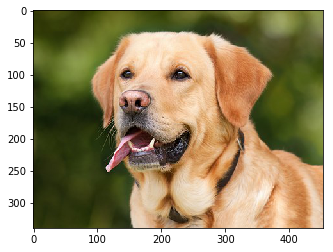

Hello, dog!
You look like a Labrador retriever.



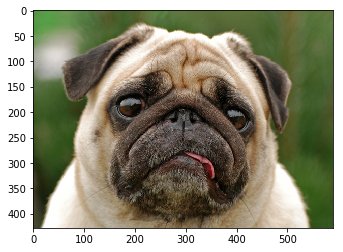

Hello, dog!
You look like a Mastiff.



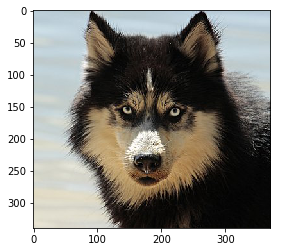

Hello, dog!
You look like a Alaskan malamute.



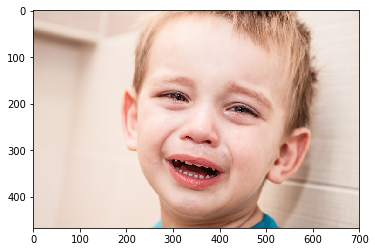

Hello, human!
You look like a Beagle.



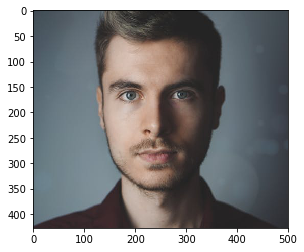

Hello, human!
You look like a Pharaoh hound.



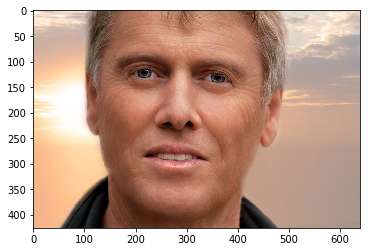

Hello, human!
You look like a Chinese crested.



In [59]:
for file in web_imgs:
    run_app(file)

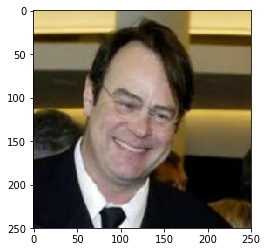

Hello, human!
You look like a Dachshund.



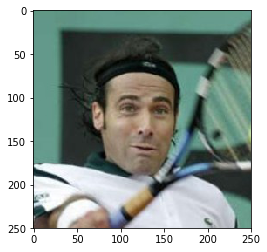

Hello, human!
You look like a American foxhound.



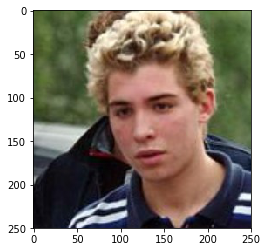

Hello, human!
You look like a Dachshund.



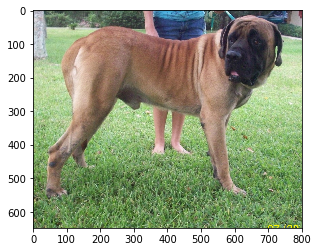

Hello, dog!
You look like a Bullmastiff.



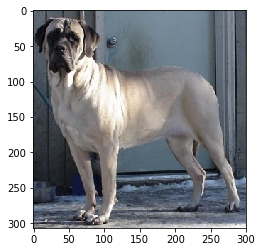

Hello, dog!
You look like a Mastiff.



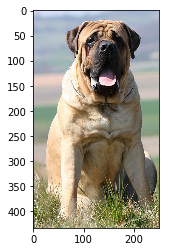

Hello, dog!
You look like a Chinese shar-pei.



In [59]:
## Test on more images

for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)